In [2]:
import pandas as pd
import DataHandler
from ModelController import ModelController
from ModelNames import ModelName
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from xgboost import XGBRanker
from tqdm import tqdm
import scipy.sparse as sps
import numpy as np


C:\Users\leoli\miniconda3\envs\RecSysFramework\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [3]:
URM_all_dataframe = pd.read_csv(filepath_or_buffer="Data/data_train.csv",
                                sep=",",
                                dtype={0:int, 1:int, 2:float},
                                engine='python')
users = pd.read_csv(filepath_or_buffer="Data/data_target_users_test.csv")

ICM = pd.read_csv(filepath_or_buffer="Data/data_ICM_metadata.csv",
                                sep=",",
                                dtype={0:int, 1:int, 2:float},
                                engine='python')

In [4]:
URM_all, ICM_all = DataHandler.create_urm_icm(URM_all_dataframe, ICM)

controller = ModelController(URM_all, ICM_all)

EvaluatorHoldout: Ignoring 438 ( 1.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 145 ( 0.4%) Users that have less than 1 test interactions


In [5]:
candidate_recommender = SLIMElasticNetRecommender(controller.URM_train_boost)
candidate_recommender.load_model(folder_path="_saved_models", file_name="SLIM_ElasticNetboost")

SLIMElasticNetRecommender: Loading model from file '_saved_modelsSLIM_ElasticNetboost'
SLIMElasticNetRecommender: Loading complete


In [6]:
n_users, n_items = controller.URM_train_boost.shape

training_dataframe = pd.DataFrame(index=range(0,n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

training_dataframe

,ItemID
UserID,
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
35731,NaN
35732,NaN
35733,NaN


In [7]:
cutoff = 30

for user_id in tqdm(range(n_users)):
    recommendations = candidate_recommender.recommend(user_id, cutoff = cutoff)
    training_dataframe.loc[user_id, "ItemID"] = recommendations

training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

100%|██████████| 35736/35736 [00:21<00:00, 1653.64it/s]


,ItemID
UserID,
0,884
0,7548
0,399
0,6380
0,22939
...,...
35735,35559
35735,34786
35735,35711


In [8]:
URM_validation_coo = sps.coo_matrix(controller.URM_validation)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,120
1,0,458
2,0,884
3,0,2600
4,0,2635
...,...,...
282332,35735,37444
282333,35735,37447
282334,35735,37546
282335,35735,37756


In [9]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe

,UserID,ItemID,Exist
0,0,884,both
1,0,7548,left_only
2,0,399,left_only
3,0,6380,left_only
4,0,22939,left_only
...,...,...,...
1072075,35735,35559,left_only
1072076,35735,34786,left_only
1072077,35735,35711,left_only
1072078,35735,35095,left_only


In [10]:
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,884,True
1,0,7548,False
2,0,399,False
3,0,6380,False
4,0,22939,False
...,...,...,...
1072075,35735,35559,False
1072076,35735,34786,False
1072077,35735,35711,False
1072078,35735,35095,False


In [11]:
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.NonPersonalizedRecommender import TopPop

top_pop = TopPop(controller.URM_train_boost)
top_pop.fit()
top_pop.save_model(folder_path="_saved_models", file_name = "TopPopBoost")


item_cf = ItemKNNCFRecommender(controller.URM_train_boost)
item_cf.fit(similarity= "cosine", topK= 8, shrink= 12)
item_cf.save_model(folder_path="_saved_models", file_name = "itemcfboost")


item_cbf = ItemKNNCBFRecommender(controller.URM_train_boost, controller.ICM_all)
item_cbf.fit()

rp3beta = RP3betaRecommender(controller.URM_train_boost)
rp3beta.fit(topK= 12, alpha= 0.5769111396825488, beta= 0.0019321798490027353)

slimbpr = SLIM_BPR_Cython(controller.URM_train_boost)
slimbpr.fit(topK= 11, learning_rate= 0.04193849345153912, lambda_i= 0.009876208709609856, lambda_j= 0.00044296738036044263, symmetric= True, sgd_mode= 'adagrad')


other_algorithms = {
    "top_pop": top_pop,
    "item_cf": item_cf,
    "item_cbf": item_cbf,
    "rp3beta": rp3beta,
    "SLIM_BPR": slimbpr
}

TopPopRecommender: Saving model in file '_saved_modelsTopPopBoost'
TopPopRecommender: Saving complete
Cython module imported successfully.
Similarity column 38121 (100.0%), 2087.62 column/sec. Elapsed time 18.26 sec
ItemKNNCFRecommender: Saving model in file '_saved_modelsitemcfboost'
ItemKNNCFRecommender: Saving complete
Cython module imported successfully.
Similarity column 38121 (100.0%), 528.37 column/sec. Elapsed time 1.20 min
RP3betaRecommender: Similarity column 38121 (100.0%), 2980.45 column/sec. Elapsed time 12.79 sec
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.
Processed 35736 ( 100.00% ) in 0.59 seconds. BPR loss is 3.08E-02. Sample per second: 60396
SLIM_BPR_Recommender: Epoch 1 of 300. Elapsed time 0.25 sec
Processed 35736 ( 100.00% ) in 0.83 seconds. BPR loss is 7.12E-02. Sample per second: 42848
SLI

In [12]:
training_dataframe = training_dataframe.set_index('UserID')

for user_id in tqdm(range(n_users)):
    for rec_label, rec_instance in other_algorithms.items():

        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()

        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list]

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

100%|██████████| 35736/35736 [32:01<00:00, 18.60it/s]  


,UserID,ItemID,Label,top_pop,item_cf,item_cbf,rp3beta,SLIM_BPR
0,0,884,True,169.0,0.080194,0.017857,0.233845,0.210312
1,0,7548,False,47.0,0.570225,0.000000,0.412468,0.797933
2,0,399,False,155.0,0.245380,0.000000,0.133510,0.367569
3,0,6380,False,189.0,0.124905,0.000000,0.000000,0.304992
4,0,22939,False,27.0,0.106792,0.000000,0.106120,0.000000
...,...,...,...,...,...,...,...,...
1072075,35735,35559,False,19.0,0.110286,0.275937,0.000000,0.211272
1072076,35735,34786,False,44.0,0.279717,0.296428,0.097572,0.538040
1072077,35735,35711,False,15.0,0.219863,0.270756,0.000000,0.268652
1072078,35735,35095,False,71.0,0.232179,0.000000,0.000000,0.000000


In [13]:

'''ICM_features = controller.ICM_all.to_dict()["feature_id"]
ICM_features'''




'ICM_features = controller.ICM_all.to_dict()["feature_id"]\nICM_features'

In [14]:
item_popularity = np.ediff1d(sps.csc_matrix(controller.URM_train_boost).indptr)

training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]

training_dataframe

,UserID,ItemID,Label,top_pop,item_cf,item_cbf,rp3beta,SLIM_BPR,item_popularity
0,0,884,True,169.0,0.080194,0.017857,0.233845,0.210312,169
1,0,7548,False,47.0,0.570225,0.000000,0.412468,0.797933,47
2,0,399,False,155.0,0.245380,0.000000,0.133510,0.367569,155
3,0,6380,False,189.0,0.124905,0.000000,0.000000,0.304992,189
4,0,22939,False,27.0,0.106792,0.000000,0.106120,0.000000,27
...,...,...,...,...,...,...,...,...,...
1072075,35735,35559,False,19.0,0.110286,0.275937,0.000000,0.211272,19
1072076,35735,34786,False,44.0,0.279717,0.296428,0.097572,0.538040,44
1072077,35735,35711,False,15.0,0.219863,0.270756,0.000000,0.268652,15
1072078,35735,35095,False,71.0,0.232179,0.000000,0.000000,0.000000,71


In [15]:
type(training_dataframe["ItemID"])

pandas.core.series.Series

In [16]:
training_dataframe = training_dataframe.sort_values("UserID").reset_index()
training_dataframe.drop(columns = ['index'], inplace=True)
training_dataframe

,UserID,ItemID,Label,top_pop,item_cf,item_cbf,rp3beta,SLIM_BPR,item_popularity
0,0,884,True,169.0,0.080194,0.017857,0.233845,0.210312,169
1,0,11584,False,9.0,0.000000,0.345138,0.070005,0.318847,9
2,0,535,False,60.0,0.178851,0.133366,0.109656,0.381990,60
3,0,471,False,207.0,0.000000,0.132686,0.000000,0.347103,207
4,0,0,False,26.0,0.000000,0.000000,0.000000,0.000000,26
...,...,...,...,...,...,...,...,...,...
1072075,35735,36773,False,34.0,0.318600,0.204291,0.217308,0.855416,34
1072076,35735,37657,False,60.0,0.463438,0.263317,0.265591,0.691207,60
1072077,35735,35095,False,71.0,0.232179,0.000000,0.000000,0.000000,71
1072078,35735,36493,False,22.0,0.588171,0.000000,0.000000,0.000000,22


In [17]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([30, 30, 30, ..., 30, 30, 30], dtype=int64)

In [18]:
n_estimators = 50
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      )

In [19]:
'''candidate_recommender = SLIMElasticNetRecommender(controller.URM_train)
candidate_recommender.fit(alpha= 0.00022742003969239836, topK= 709, l1_ratio= 0.1488442906776265)
candidate_recommender.save_model(folder_path="_saved_models", file_name = "ModelName.SLIM_ElasticNetTrain")'''

'candidate_recommender = SLIMElasticNetRecommender(controller.URM_train)\ncandidate_recommender.fit(alpha= 0.00022742003969239836, topK= 709, l1_ratio= 0.1488442906776265)\ncandidate_recommender.save_model(folder_path="_saved_models", file_name = "ModelName.SLIM_ElasticNetTrain")'

In [20]:
# Check the data types of the columns in training_dataframe
print(training_dataframe.dtypes)

# Convert unsupported data types to supported ones
for column in training_dataframe.columns:
    if training_dataframe[column].dtype not in [int, float, bool, 'category']:
        training_dataframe[column] = training_dataframe[column].astype(float)

# Verify the data types after conversion
print(training_dataframe.dtypes)
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])

XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

UserID               int64
ItemID              object
Label                 bool
top_pop            float64
item_cf            float64
item_cbf           float64
rp3beta            float64
SLIM_BPR           float64
item_popularity      int32
dtype: object
UserID             float64
ItemID             float64
Label                 bool
top_pop            float64
item_cf            float64
item_cbf           float64
rp3beta            float64
SLIM_BPR           float64
item_popularity      int32
dtype: object


XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=0, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=50,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

In [21]:
# Let's say I want to compute the prediction for a group of user-item pairs, for simplicity I will use a slice of the data used
# for training because it already contains all the features
X_to_predict = X_train[X_train["UserID"] == 10]

XGB_model.predict(X_to_predict)

array([-0.24317619, -0.20310414,  0.13900565, -0.24317619, -0.22197767,
       -0.10441317, -0.22879507, -0.12396012, -0.02182585, -0.23869449,
       -0.23869449, -0.24182582, -0.23869449, -0.20490575, -0.10441317,
       -0.12769733, -0.23672861, -0.24913947,  0.08543003,  0.13616839,
        0.04920474, -0.25350186, -0.11087089,  0.34798875, -0.25153598,
       -0.24121031, -0.24717359, -0.24317619, -0.08700582, -0.11802834],
      dtype=float32)

<AxesSubplot:title={'center':'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

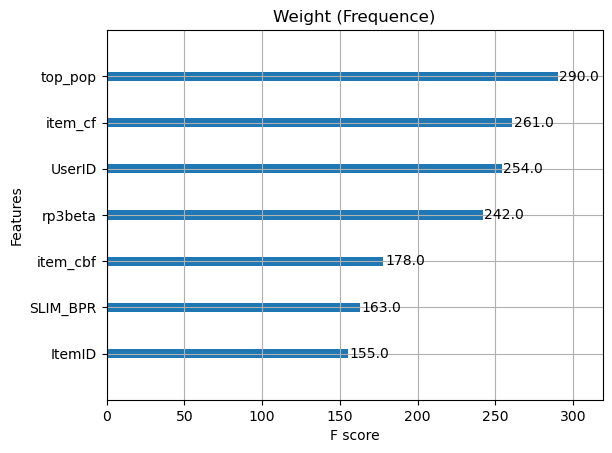

In [22]:
from xgboost import plot_importance

plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

In [23]:
X_train["UserID"] = X_train["UserID"].astype("category")
X_train["ItemID"] = X_train["ItemID"].astype("category")

In [24]:
XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      enable_categorical = True,
                      tree_method = "hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
                      )

XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=True,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=0, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=50,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

In [25]:
X_to_predict = X_train[X_train["UserID"] == 10]

XGB_model.predict(X_to_predict)

array([-0.08741126, -0.08741126, -0.02803878, -0.08741126, -0.08217078,
       -0.04054259, -0.08741126, -0.04054259, -0.22777617, -0.08741126,
       -0.08741126, -0.08741126, -0.08741126, -0.04323774, -0.04054259,
       -0.0563749 , -0.08741126, -0.08741126,  0.05856968,  0.08488489,
       -0.02803878, -0.08741126, -0.02803878, -0.08253983, -0.08741126,
       -0.08741126, -0.08741126, -0.08741126, -0.229092  ,  0.03760615],
      dtype=float32)

<AxesSubplot:title={'center':'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

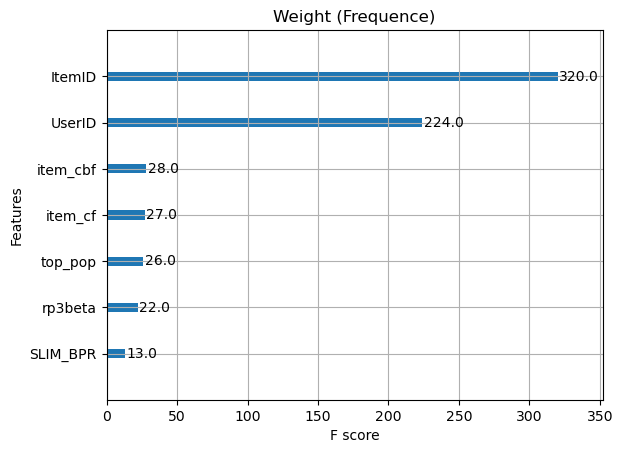

In [26]:
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')